In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 98% 526M/534M [00:03<00:00, 131MB/s]
100% 534M/534M [00:03<00:00, 152MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/vegetable-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/data/Vegetable Images/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/data/Vegetable Images/validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

# Define a callback for printing the learning rate at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [ ]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2,mode="min",restore_best_weights=True,),
    PrintLR()
]

In [ ]:

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, steps_per_epoch=468, callbacks=callbacks,
                    validation_data = validation_generator, 
                    verbose = 1, validation_steps=93)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
class_names = train_generator.class_names
print(class_names)

AttributeError: ignored

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def pred(fn):
  path =  fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(Classes[np.argmax(classes[0])])
  img = mpimg.imread(fn)
  imgplot = plt.imshow(img)
  plt.show()

In [ ]:
Classes=['Bean', 'Bitter_Groud', 'Bottle_Gourd', 'Brinjal', 'Broccoli','Cabbage','Capsicum','Carrot','Cauliflower','Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

Cauliflower


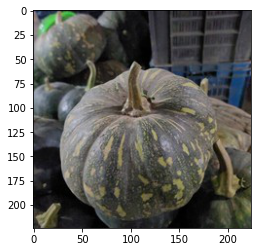

In [ ]:
pred('/content/data/Vegetable Images/test/Papaya/1202.jpg')

In [ ]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1

    true=filedir.split('/')[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))

    for subplot, imggg in enumerate(images):
        img = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_toarray(img)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))


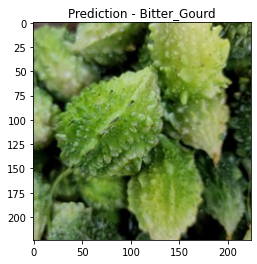

In [ ]:
predict_image(os.path.join('/content/data/Vegetable Images/test/Bitter_Gourd/','1202.jpg'),model)

In [ ]:
model.save('/content/model.h5')